# 0. Load Libraries

In [1]:
import sys
import json
import numpy as np
import pandas as pd
import models
import utils
from matplotlib import pyplot as plt
from classes import  Locatable, Satellite, Cluster, Vehicle
from drawingmap import DrawingMap

In [2]:
pd.set_option('display.max.row',None)
pd.set_option('display.max.column',None)

# 1. Load Data

## 1.1. Satellites

In [3]:
satellites, df_satellites = utils.LoadingData.load_satellites(DEBUG=False)
print(f'Cantidad de satellites cargados: {len(satellites)}')

Cantidad de satellites cargados: 9


## 1.2. Customer Clusters

In [4]:
clusters, df_clusters = utils.LoadingData.load_customer_clusters(DEBUG=False)
print(f'Cantidad de clusters cargados: {len(clusters)}')

Cantidad de clusters cargados: 122


## 1.3. Load Vehicles

In [5]:
small_vehicle = Vehicle(id='small'
                        , type='small'
                        , capacity=115 #115
                        , costFixed=89
                        , time_service=0.002
                        , time_fixed=0.05
                        , time_load=0.0071
                        , time_dispatch=0.33
                        , speed_line=30
                        , Tmax=12
                        , k=1.3)
large_vehicle = Vehicle(id='large'
                        , type='large'
                        , capacity=460
                        , costFixed=139
                        , time_service=0.02
                        , time_fixed=0.05
                        , time_load=0.0071
                        , time_dispatch=0.75
                        , speed_line=25
                        , Tmax=12
                        , k=1.3)

## 1.4. Load Matrixes: Distance and Durations with and without traffic

### 1.4.1. From Satellites to Clusters

In [6]:
matrixes_from_satellites = utils.LoadingData.load_distances_duration_matrix_from_satellite()

### 1.4.2. From DC to Clusters

In [7]:
matrixes_from_dc = utils.LoadingData.load_distances_duration_matrix_from_dc()

# 2. Drawing Map

## 2.1. La Paz with customer segments

In [8]:
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)

drawer = DrawingMap(location_la_paz)

drawer.addNodes(list_locatables=list(clusters.values()), color="blue", radius=4)
drawer.addNodes(list_locatables=list(satellites.values()), color='red', radius=3)
drawer.addMarker(location=location_DC, label='DC')

drawer.viewMap()

# 3. Generate Params

In [9]:
PERIODS = 12
params_gurobi = {
    'TimeLimit':1000,
    'MIPGap':0.02
}
CAPACITY_FIXED = 12

## 3.1. Average Fleet Size
#### a) From Satellite to Customer Cluster

In [10]:
config_ = utils.ConfigDeterministic()
fleet_size_satellites = config_.calculate_avg_fleet_size_from_satellites(satellites=list(satellites.values())
                                                                         , clusters=list(clusters.values())
                                                                         , vehicle=small_vehicle
                                                                         , periods=PERIODS
                                                                         , distances_linehaul=matrixes_from_satellites['distance'])

#### b) From DC to Customer Cluster

In [11]:
fleet_size_dc = config_.calculate_avg_fleet_size_from_dc(clusters=clusters.values(), vehicle=large_vehicle, periods=PERIODS
                                                         , distances_linehaul=matrixes_from_dc['distance'])

In [12]:
fleet_size_required = {
    'small': fleet_size_satellites,
    'large': fleet_size_dc
}

## 3.3. Cost *$c_{sk}^{t}$* and *$g_{k}{t}$*
### 3.3.1. Avg distance from satellites

In [13]:
distance_average_from_satellites = {}
for s in satellites.values():
    min_distances, max_distances = sys.maxsize, -sys.maxsize - 1
    for k in clusters.values():
        min_distances = min_distances if matrixes_from_satellites['distance'][(s.id, k.id)] > min_distances else matrixes_from_satellites['distance'][(s.id, k.id)]
        max_distances = max_distances if matrixes_from_satellites['distance'][(s.id, k.id)] < max_distances else matrixes_from_satellites['distance'][(s.id, k.id)]
    distance_average_from_satellites[s.id] = {'min': min_distances, 'max': max_distances, 'interval': max_distances-min_distances, 'cost': 0.421 - 0.335}
#distance_average_from_satellites

### 3.3.2. Avg distances from dc

In [14]:
distance_average_from_dc = {}
min_distances, max_distances = sys.maxsize, -sys.maxsize - 1
for k in clusters.values():
    min_distances = min_distances if matrixes_from_dc['distance'][(k.id)] > min_distances else matrixes_from_dc['distance'][(k.id)]
    max_distances = max_distances if matrixes_from_dc['distance'][(k.id)] < max_distances else matrixes_from_dc['distance'][(k.id)]
distance_average_from_dc = {'min': min_distances, 'max': max_distances, 'interval': max_distances-min_distances, 'cost': 0.389 - 0.264}
distance_average_from_dc

{'min': 4.828, 'max': 25.26, 'interval': 20.432000000000002, 'cost': 0.125}

## 3.3. Cost of Shipping based in fixed-fee

In [15]:
fee_cost_from_satellites = 0.389 #0.071
fee_cost_from_dc = 0.335 #0.06

cost_shipping_from_satellites = dict([
    ((s.id, k.id), distance_average_from_satellites[(s.id)]['cost']/distance_average_from_satellites[(s.id)]['interval']*\
     (matrixes_from_satellites['distance'][(s.id, k.id)] - distance_average_from_satellites[(s.id)]['min']) +  0.335) for s in satellites.values() for k in clusters.values()
])

cost_shipping_from_dc = dict([
    (k.id, distance_average_from_dc['cost']/distance_average_from_dc['interval']* (matrixes_from_dc['distance'][(k.id)] - distance_average_from_dc['min']) +  0.264)for k in clusters.values()
])

SATELLITES: max: 0.421 - min: 0.335 - mean 0.375
DC: max: 0.389 - min: 0.264 - mean 0.333


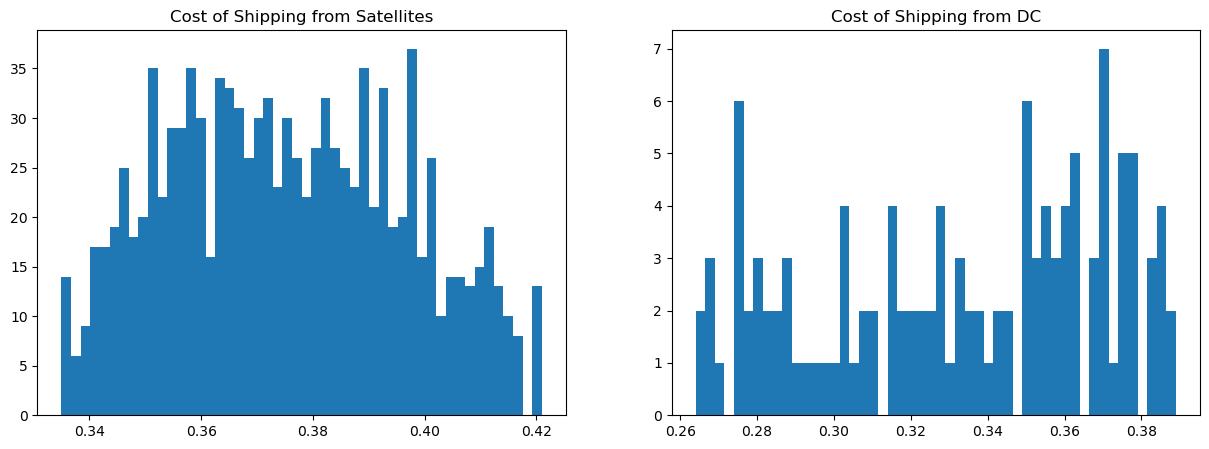

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# ax-1
aux_1 = [item for item in list(cost_shipping_from_satellites.values()) if item!=0]
# ax-2
aux_2 = [item for item in list(cost_shipping_from_dc.values()) if item!=0]
print(f'SATELLITES: max: {np.max(aux_1):.3f} - min: {np.min(aux_1):.3f} - mean {np.mean(aux_1):.3f}')
print(f'DC: max: {np.max(aux_2):.3f} - min: {np.min(aux_2):.3f} - mean {np.mean(aux_2):.3f}')
axes[0].hist(aux_1, bins=50)
axes[0].set_title("Cost of Shipping from Satellites")
axes[1].hist(aux_2, bins=50)
axes[1].set_title('Cost of Shipping from DC')
plt.show()

## 3.4. Operational Total Cost

In [17]:
def cost_satellite_cluster_period(satellites: list[Satellite],
                                  clusters: list[Cluster],
                                  cost_shipping_satellite: dict[(str, str), float],
                                  vehicle_small: Vehicle,
                                  periods: int,
                                  vehicles_required: dict[str, dict]) -> dict[(str,str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            for s in satellites:
                cost_first_level = (s.costSourcing*k.demandByPeriod[t])
                cost_shipping = (cost_shipping_satellite[(s.id, k.id)]*k.demandByPeriod[t])
                cost_vehicles = (vehicle_small.costFixed*vehicles_required['small'][(s.id, k.id, t)]['fleet_size'])
                total_cost = cost_first_level + cost_shipping + cost_vehicles
                costs[(s.id, k.id, t)] = {'total': total_cost, 'first_level': cost_first_level
                                        ,'shipping': cost_shipping, 'vehicles':cost_vehicles}
    return costs

def cost_dc_cluster_period(clusters: list[Cluster],
                           cost_shipping_dc: dict[str, float],
                           vehicle_large: Vehicle,
                           periods: int,
                           vehicles_required: dict[str, dict]) -> dict[(str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            cost_shipping =(cost_shipping_dc[k.id] * k.demandByPeriod[t]) 
            cost_vehicles = (vehicle_large.costFixed * vehicles_required['large'][(k.id, t)]['fleet_size'])
            total_cost = cost_shipping + cost_vehicles 
            costs[(k.id, t)] = {'total': total_cost, 'shipping': cost_shipping, 'vehicles': cost_vehicles}
    return costs

In [18]:
cost_C = cost_satellite_cluster_period(list(satellites.values()), list(clusters.values())
                                       ,cost_shipping_satellite=cost_shipping_from_satellites
                                       ,vehicle_small=small_vehicle
                                       ,periods=PERIODS
                                       ,vehicles_required=fleet_size_required)

cost_G = cost_dc_cluster_period(clusters.values()
                                ,cost_shipping_dc=cost_shipping_from_dc
                                ,vehicle_large=large_vehicle
                                ,periods=PERIODS
                                ,vehicles_required=fleet_size_required)

max: 881.0869643400772 - min: 1.6849981843514263 - mean 111.20419980099523


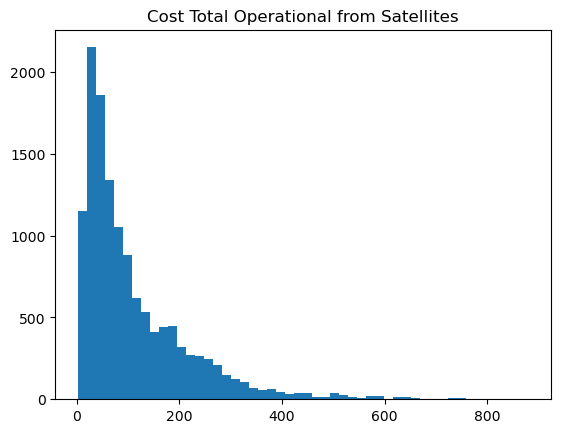

In [19]:
aux = [item['total'] for item in list(cost_C.values()) if item['total']!=0]
print(f'max: {np.max(aux)} - min: {np.min(aux)} - mean {np.mean(aux)}')
plt.hist(aux, bins=50)
plt.title("Cost Total Operational from Satellites")
plt.show()

max: 853.1501258262315 - min: 2.337326794276194 - mean 115.98911671848332


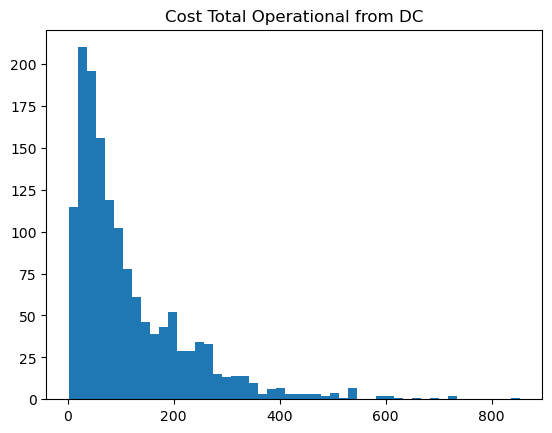

In [20]:
aux = [item['total'] for item in list(cost_G.values()) if item['total']!=0]
print(f'max: {np.max(aux)} - min: {np.min(aux)} - mean {np.mean(aux)}')
plt.hist(aux, bins=50)
plt.title("Cost Total Operational from DC")
plt.show()

## 3.5. Income per Satellite and Cluster

In [21]:
cost_operation = {
    'satellite': cost_C,
    'dc': cost_G,
    #'min_items_satellite': 89, # 155
    #'min_items_dc': 119, #290,
    #'fee_required_from_satellite': fee_required_from_satellite,
    #'fee_required_from_dc': fee_required_from_cd
}

# 4. Model Deterministic

In [22]:
model_ = models.ModelDeterministic(periods=PERIODS)
model_.setParams(params=params_gurobi)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-13
Set parameter TimeLimit to value 1000
Set parameter MIPGap to value 0.02


In [23]:
model_.build(satellites=list(satellites.values())
             ,clusters=list(clusters.values())
             ,vehicles_required=fleet_size_required
             ,costs=cost_operation
             ,cap_max=CAPACITY_FIXED)

Discarded solution information


{'time_building': 1}

In [24]:
print(model_.optimizeModel())

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 15405 rows, 15342 columns and 122010 nonzeros
Model fingerprint: 0xd3722ca6
Variable types: 0 continuous, 15342 integer (15342 binary)
Coefficient statistics:
  Matrix range     [8e-03, 1e+01]
  Objective range  [2e+00, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 169344.11041
Presolve removed 2471 rows and 3887 columns
Presolve time: 0.09s
Presolved: 12934 rows, 11455 columns, 98757 nonzeros
Variable types: 0 continuous, 11455 integer (11455 binary)

Root relaxation: objective 1.594759e+05, 7097 iterations, 0.30 seconds (0.67 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 159475.934    0 3643 169344.110 159

In [25]:
cost_allocation_satellites = np.sum([
    (s.costFixed[q_id]/(25*12)) * model_.Y[(s.id, q_id)].x for s in list(satellites.values()) for q_id in s.capacity.keys() if CAPACITY_FIXED >= int(q_id)
])
cost_operating_satellites = np.sum([
    (s.costOperation[q_id][t]/25) * model_.X[(s.id, q_id, t)].x for s in list(satellites.values()) for q_id in s.capacity.keys() for t in range(PERIODS) if CAPACITY_FIXED >= int(q_id)
])
cost_served_from_satellite = np.sum([
    cost_operation['satellite'][(s.id, k.id, t)]['total'] * model_.Z[(s.id, k.id, t)].x for s in list(satellites.values()) for k in
    list(clusters.values()) for t in
    range(PERIODS)
])
cost_served_from_dc = np.sum([
    cost_operation['dc'][(k.id, t)]['total'] * model_.W[(k.id, t)].x for k in list(clusters.values()) for t in range(PERIODS)
])

In [26]:
total_cost = cost_allocation_satellites + cost_operating_satellites + cost_served_from_satellite + cost_served_from_dc
print(f'cost allocation satellites: {cost_allocation_satellites:.2f} ({(cost_allocation_satellites*100/total_cost):.2f} %)\n'+\
    f'cost operating satellites: {cost_operating_satellites:.2f} ({(cost_operating_satellites*100/total_cost):.2f} %)\n'+\
    f'cost served from satellite: {cost_served_from_satellite:.2f} ({(cost_served_from_satellite*100/total_cost):.2f} %)\n'+\
    f'cost served from dc: {cost_served_from_dc:.2f} ({(cost_served_from_dc*100/total_cost):.2f} %)')
print(total_cost)

cost allocation satellites: 220.32 (0.14 %)
cost operating satellites: 5682.44 (3.49 %)
cost served from satellite: 76087.10 (46.67 %)
cost served from dc: 81037.13 (49.71 %)
163026.99774334568


## 4.1. Get results

In [27]:
variables_results = model_.get_results(satellites=list(satellites.values())
                                      ,clusters=list(clusters.values()), max_capacity=CAPACITY_FIXED)

### 4.1.1. Y

In [28]:
for k, v in variables_results['Y'].items():
    print(f'id: {k[0]} cap: {k[1]}')

id: Abaroa cap: 12
id: Achachicala cap: 12
id: Periferica cap: 12
id: Los Pinos cap: 10


### 4.1.2. X

In [29]:
for t in range(PERIODS):
    print(f'## t - {t}', end=" ")
    for k, v in variables_results['X'][t].items():
        print(f'id: {v.id} - {k[1]}', end=" | ")
    print("")

## t - 0 id: Los Pinos - 10 | 
## t - 1 id: Los Pinos - 10 | 
## t - 2 id: Los Pinos - 10 | 
## t - 3 id: Los Pinos - 10 | 
## t - 4 id: Achachicala - 12 | id: Los Pinos - 10 | 
## t - 5 id: Achachicala - 12 | id: Los Pinos - 10 | 
## t - 6 id: Los Pinos - 10 | 
## t - 7 id: Abaroa - 12 | id: Los Pinos - 10 | 
## t - 8 id: Los Pinos - 10 | 
## t - 9 id: Los Pinos - 10 | 
## t - 10 id: Periferica - 12 | id: Los Pinos - 10 | 
## t - 11 id: Periferica - 12 | id: Los Pinos - 10 | 


In [30]:
variables_results['X'][0]

{('Los Pinos', '10'): <classes.Satellite at 0x13e5e3550>}

In [31]:
variables_results['Y']


{('Abaroa', '12'): <classes.Satellite at 0x13e5e3580>,
 ('Achachicala', '12'): <classes.Satellite at 0x13e5e1360>,
 ('Periferica', '12'): <classes.Satellite at 0x13e5e35b0>,
 ('Los Pinos', '10'): <classes.Satellite at 0x13e5e3550>}

### 4.1.3. W - demand served from DC

In [32]:
period_selected = 11
lista_clusters = variables_results['W'][period_selected]
# map
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
drawer.addNodes(list_locatables=lista_clusters, color="black", radius=12)
drawer.addMarker(location=location_DC, label='DC')
drawer.viewMap()

### 4.1.4. Z - demand served from DC

In [33]:
map_colors = {
    'Abaroa': 'pink',
    'Llojeta': 'green',
    'Cota Cota': 'blue',
    'Achachicala': 'darkgreen',
    'Mallasa': 'black',
    'Sopocachi': 'gray',
    'Periferica': 'darkred',
    'Zona Cementerio': 'orange',
    'Los Pinos': 'purple'
}

In [41]:
period_selected = 11
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
for k, v in map_colors.items():
    satellite_selected = k
    lista_clusters = variables_results['Z'][period_selected][satellite_selected]
    if len(lista_clusters) == 0:
        continue
    # map
    drawer.addNodes(list_locatables=lista_clusters, color=v, radius=12)
    drawer.addMarker(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), label=satellite_selected)

lista_clusters = variables_results['W'][period_selected]
drawer.addNodes(list_locatables=lista_clusters, color="black", radius=12)
drawer.addMarker(location=location_DC, label='DC')
drawer.viewMap()

## 4.2. Metrics

### 4.2.1. Vehicles Required

In [35]:
def obtain_vehicles_required_in_satellite(satellite: Satellite, clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(satellite.id, c.id, period)]['fleet_size']
    return np.ceil(vehicles_sum)

vehicles_required_results = dict([
    (s.id, [obtain_vehicles_required_in_satellite(s
                                     ,clusters_served=variables_results['Z'][t][s.id]
                                     ,period=t
                                     ,vehicles_required=fleet_size_satellites) for t in range(PERIODS)]) for s in list(satellites.values())
])
df_vehicles_satellite = pd.DataFrame(vehicles_required_results)
df_vehicles_satellite
#print(json.dumps(vehicles_required_results, indent=2))

,Abaroa,Llojeta,Cota Cota,Achachicala,Mallasa,Sopocachi,Periferica,Zona Cementerio,Los Pinos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,10.0
5,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,10.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
7,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0


In [36]:
def obtain_vehicles_required_in_dc(clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(c.id, period)]['fleet_size']
    return np.ceil(vehicles_sum)

vehicles_required_results =[ obtain_vehicles_required_in_dc(clusters_served=variables_results['W'][t]
                                                  ,period=t
                                                  ,vehicles_required=fleet_size_dc) for t in range(PERIODS)
]
df_vehicles_dc = pd.DataFrame(vehicles_required_results, columns=['DC'])
df_vehicles_dc
#print(json.dumps(vehicles_required_results, indent=2))

,DC
0,27.0
1,39.0
2,38.0
3,34.0
4,11.0
5,23.0
6,33.0
7,8.0
8,38.0
9,44.0


### 4.2.2. % Demand served from Satellites

In [37]:
demand_by_period = []
for t in range(PERIODS):
    sum_ = 0
    for c in list(clusters.values()):
        sum_ += c.demandByPeriod[t]
    demand_by_period.append(np.ceil(sum_))
df_demand_dc = pd.DataFrame(demand_by_period, columns=['TotalDemand'])
df_demand_dc

,TotalDemand
0,14713.0
1,19924.0
2,19029.0
3,17513.0
4,17781.0
5,23028.0
6,17391.0
7,16362.0
8,19406.0
9,21853.0


In [38]:
pd.set_option('display.max.columns', None)
resumen ={}
for s in list(satellites.values()):
    demand_served = []
    for t in range(PERIODS):
        sum_ = 0
        for c in variables_results['Z'][t][s.id]:
            sum_ += c.demandByPeriod[t]
        demand_served.append(np.ceil(sum_))
    per_demand_served = np.round(np.array(demand_served) / np.array(demand_by_period),2)
    resumen[s.id] = {
        'demand_served': demand_served,
        'per_demand_served': per_demand_served.tolist()
    }
df_demand_satellite = pd.DataFrame(resumen).T
print("FROM SATELLITES: ")
display(df_demand_satellite)
print(json.dumps(resumen, indent=2))

FROM SATELLITES: 


,demand_served,per_demand_served
Abaroa,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7765.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47, 0.0,..."
Llojeta,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Cota Cota,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Achachicala,"[0.0, 0.0, 0.0, 0.0, 7649.0, 8309.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.43, 0.36, 0.0, 0.0, 0.0..."
Mallasa,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Sopocachi,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Periferica,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Zona Cementerio,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Los Pinos,"[5712.0, 6445.0, 6187.0, 6153.0, 6273.0, 6446....","[0.39, 0.32, 0.33, 0.35, 0.35, 0.28, 0.36, 0.3..."


{
  "Abaroa": {
    "demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      7765.0,
      0.0,
      0.0,
      0.0,
      0.0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.47,
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "Llojeta": {
    "demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "Cota Cota": {
    "demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0
    ],
    "per_demand_served": [
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
 

### 4.2.3. % Demand served from DC

In [39]:
demand_served = []
for t in range(PERIODS):
    sum_ = 0
    for c in variables_results['W'][t]:
        sum_ += c.demandByPeriod[t]
    demand_served.append(np.ceil(sum_))
per_demand_served = np.round(np.array(demand_served) / np.array(demand_by_period),2)
resumen = {
    'demand_served': demand_served,
    'per_demand_served': per_demand_served.tolist()
}
df_demand_dc = pd.DataFrame(resumen).T
print("FROM DC: ")
df_demand_dc
#print(json.dumps(resumen, indent=2))

FROM DC: 


,0,1,2,3,4,5,6,7,8,9,10,11
demand_served,9002.00,13479.00,12843.00,11361.00,3860.00,8275.00,11101.00,2777.00,12911.00,15222.0,6518.00,9822.0
per_demand_served,0.61,0.68,0.67,0.65,0.22,0.36,0.64,0.17,0.67,0.7,0.31,0.4


In [40]:
for t in range(PERIODS):
    sum=0
    for k, v in fleet_size_dc.items():
        if k[1]==t:
            sum+=v['fleet_size']
    print(f't: {t} - fleet: {np.ceil(sum)}')

t: 0 - fleet: 45.0
t: 1 - fleet: 59.0
t: 2 - fleet: 57.0
t: 3 - fleet: 53.0
t: 4 - fleet: 53.0
t: 5 - fleet: 67.0
t: 6 - fleet: 52.0
t: 7 - fleet: 49.0
t: 8 - fleet: 57.0
t: 9 - fleet: 64.0
t: 10 - fleet: 62.0
t: 11 - fleet: 72.0
